# Including a starting model
Here we will expand the `simple_inversion.ipynb` example by showing how to incorporate a non-flat starting model. A typical scenario for where this is useful is if you have a few point measurements of the elevations of the surface you are aiming to recover. These point measurements, referred to here as `constraints`, may be boreholes, acoustic basement from seismic surveys, or other types of measurements.

## Import packages

In [22]:
%load_ext autoreload
%autoreload 2

import os

from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get a synthetic model
Here we will load synthetic topography data, calculate its forward gravity with added noise, and sample the topography at 10 random points which represent places we have measurements of the topography (from boreholes for example). We will then interpolate these 10 points to make a starting model of topography.

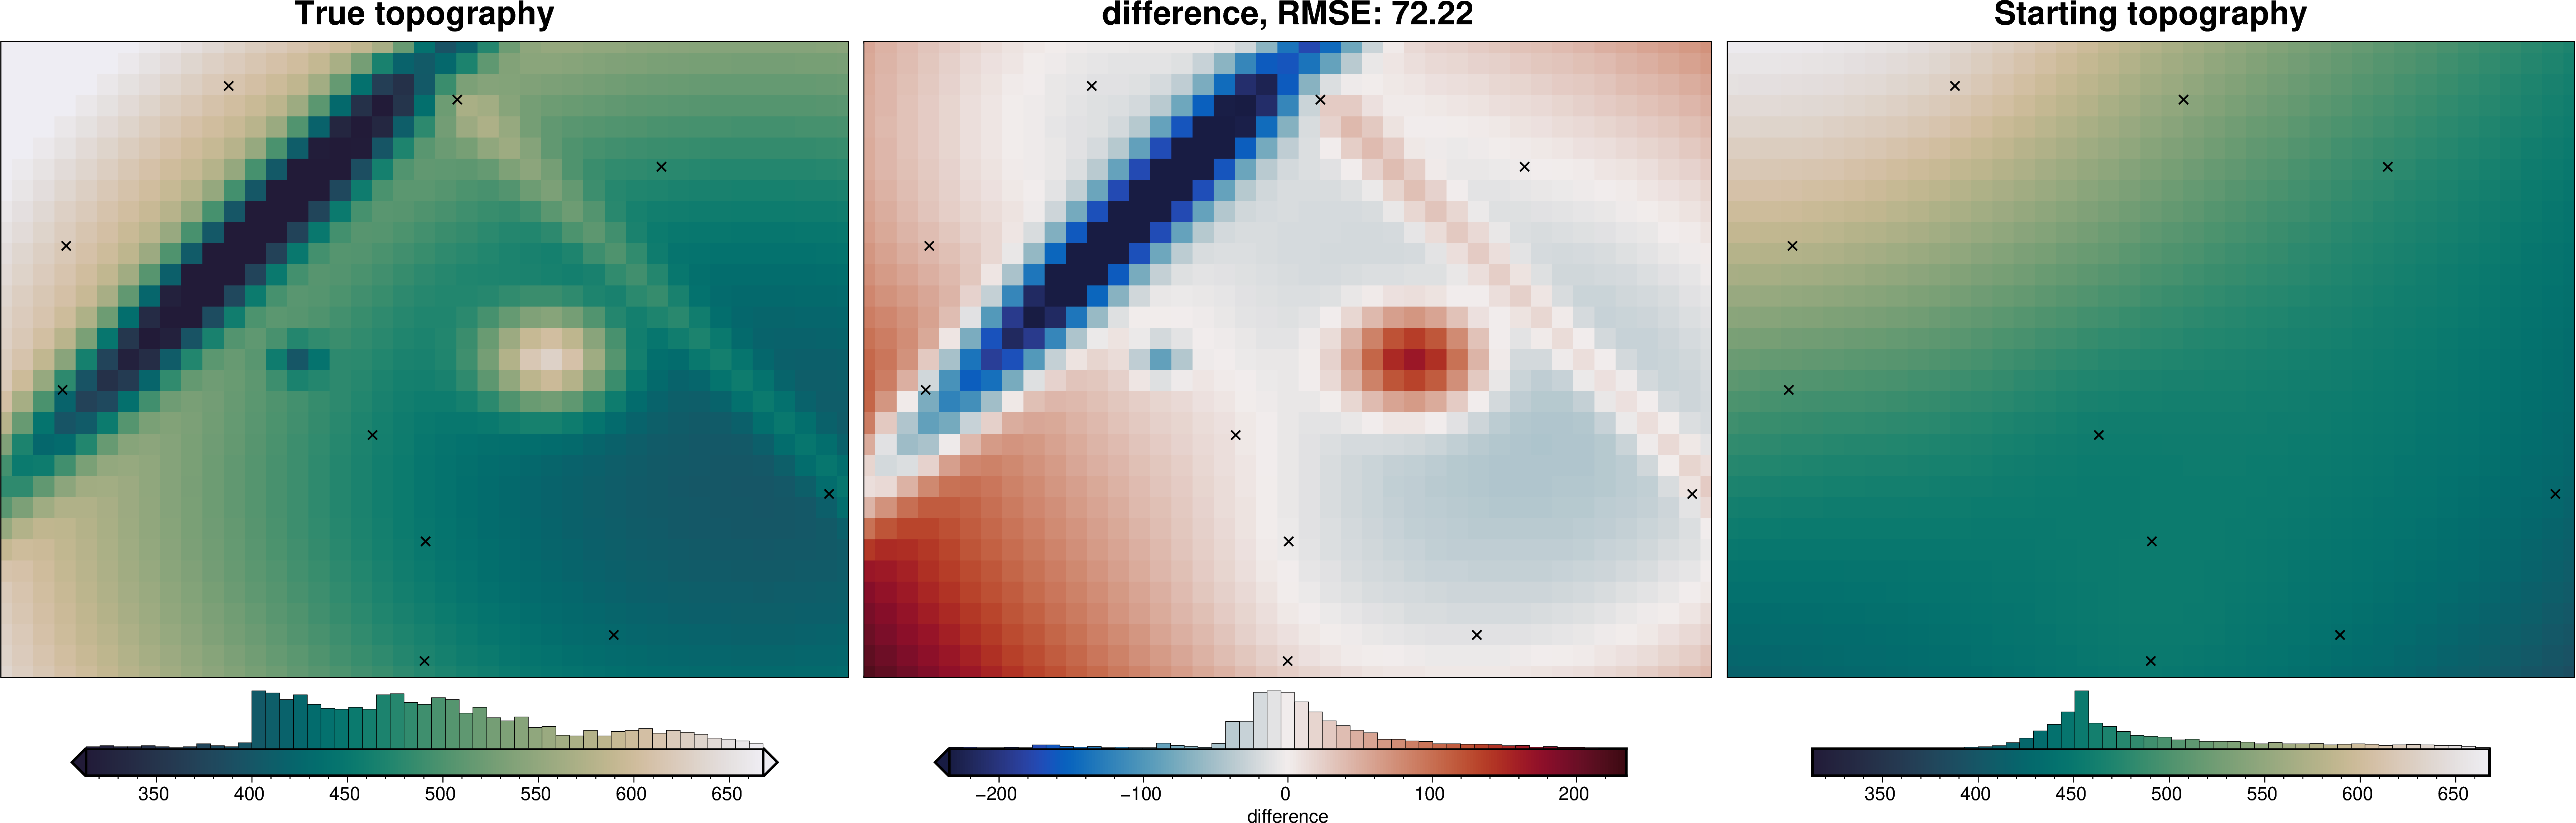

plotting failed with error: 'DataArray' object has no attribute 'to_xarray'


In [23]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

(
    true_topography,
    starting_topography,
    constraint_points,
    observed_gravity,
) = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    number_of_constraints=10,
    density_contrast=density_contrast,
)

## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

In [24]:
data = invert4geom.create_data(observed_gravity)
data

<xarray.Dataset> Size: 21kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.57 10.41 ... 3.12 2.973
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data

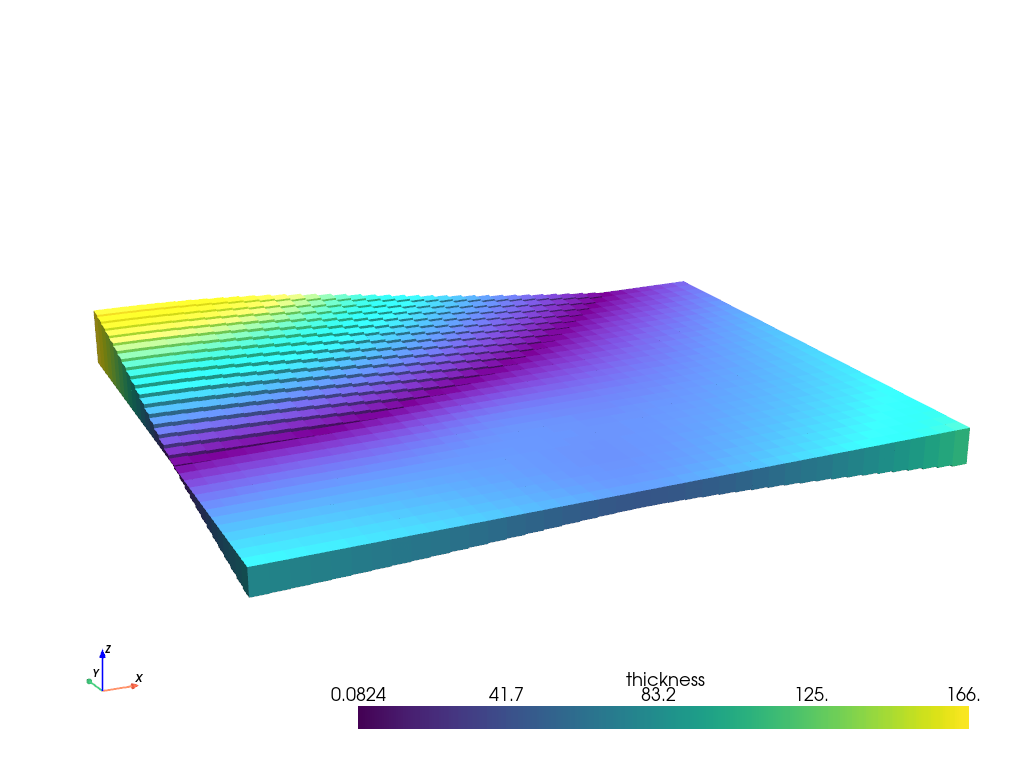

In [25]:
model = invert4geom.create_model(
    # set the reference level to the mean of the constraints
    zref=constraint_points.upward.mean(),
    density_contrast=density_contrast,
    starting_topography=starting_topography.to_dataset(name="upward"),
)
invert4geom.show_prism_layers(
    model,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [26]:
model

<xarray.Dataset> Size: 92kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
    top                    (northing, easting) float64 10kB 496.3 ... 496.3
    bottom                 (northing, easting) float64 10kB 418.5 ... 468.7
Data variables:
    density                (northing, easting) int64 10kB -2669 -2669 ... -2669
    thickness              (northing, easting) float64 10kB 77.84 ... 27.62
    starting_topography    (northing, easting) float64 10kB 418.5 ... 468.7
    topography             (northing, easting) float64 10kB 418.5 ... 468.7
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
Attributes:
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    zref:              496.3097858411461
    density_contrast:  2669
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0
    dataset_type:      model

  0%|          | 0/1271 [00:00<?, ?it/s]

makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!


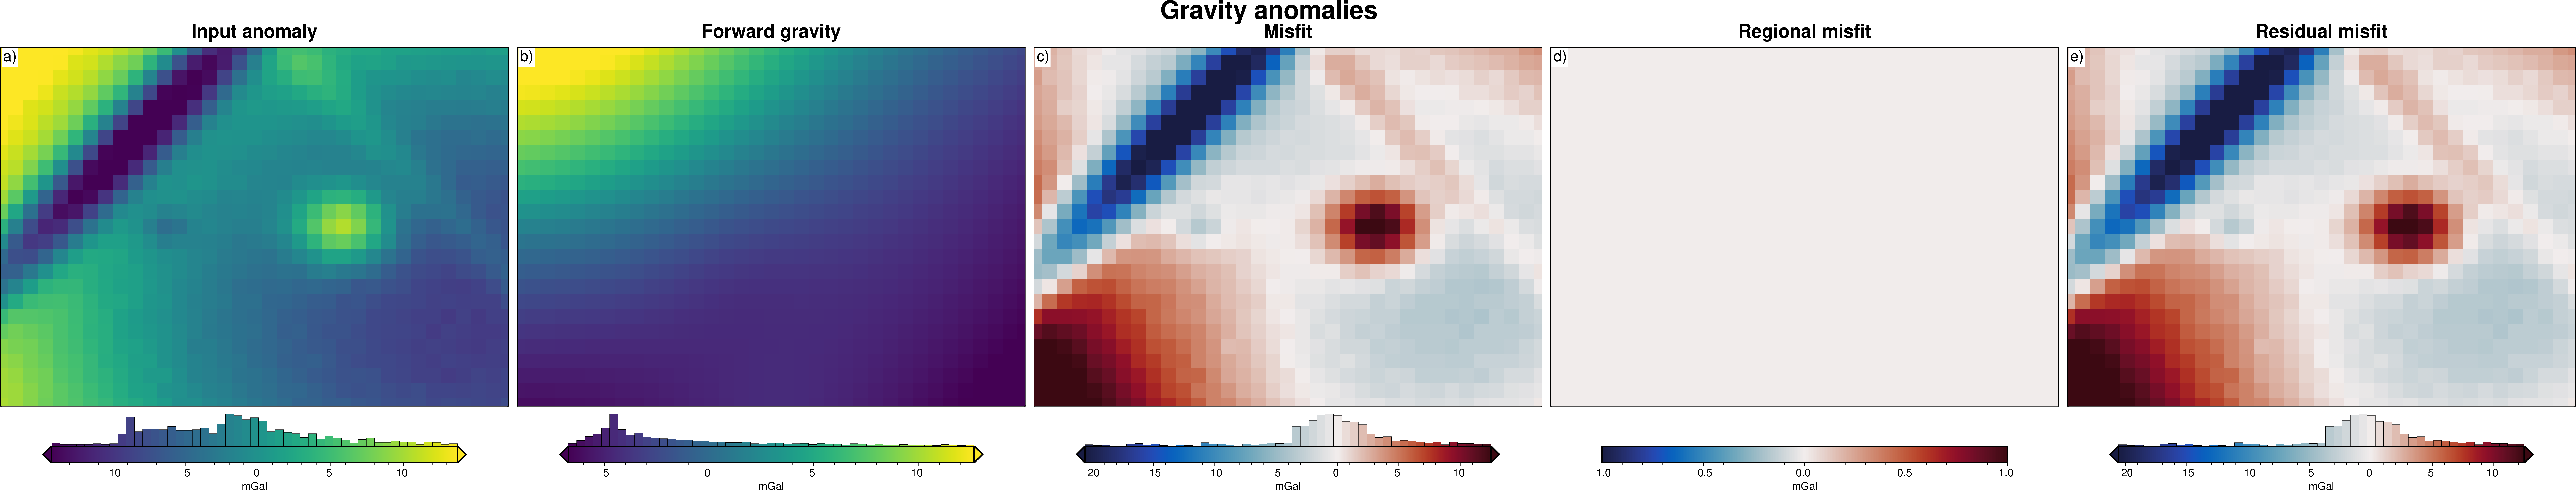

<xarray.Dataset> Size: 92kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.57 10.41 ... 3.12 2.973
    forward_gravity  (northing, easting) float64 10kB -4.617 -5.479 ... -1.716
    misfit           (northing, easting) float64 10kB 14.19 15.89 ... 4.689
    reg              (northing, easting) int64 10kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    res              (northing, easting) float64 10kB 14.19 15.89 ... 4.689
    starting_misfit  (northing, easting) float64 10kB 14.19 15.89 ... 4.689
    starting_reg     (northing, easting) int64 10kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    starting_res     (northing, easting) float64 10kB 14.19 15.89 ... 4.689
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data

In [27]:
data.inv.forward_gravity(
    model,
    progressbar=True,
)

# estimate regional with the mean misfit at constraints
data.inv.regional_separation(
    method="constant",
    constant=0,
)

data.inv.plot_anomalies()
data

## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

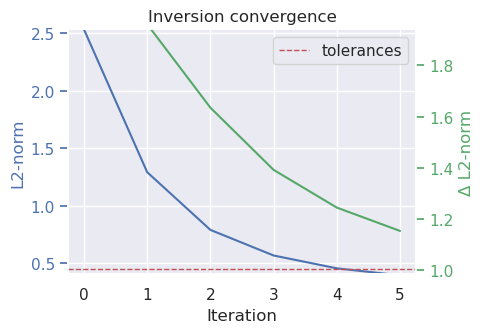

In [28]:
# setup the inversion
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.06,
    # set stopping criteria
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
)

# run the inversion
inv.invert(
    plot_convergence=True,
)

In [29]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,6.432235,2.536185,inf,NaN
1,1.0,1.672730,1.293341,1.960957,0.480812
2,2.0,0.625735,0.791034,1.635000,0.539939
3,3.0,0.322842,0.568192,1.392195,0.362273
4,4.0,0.208302,0.456401,1.244941,0.349606
5,5.0,0.156465,0.395557,1.153819,0.322825


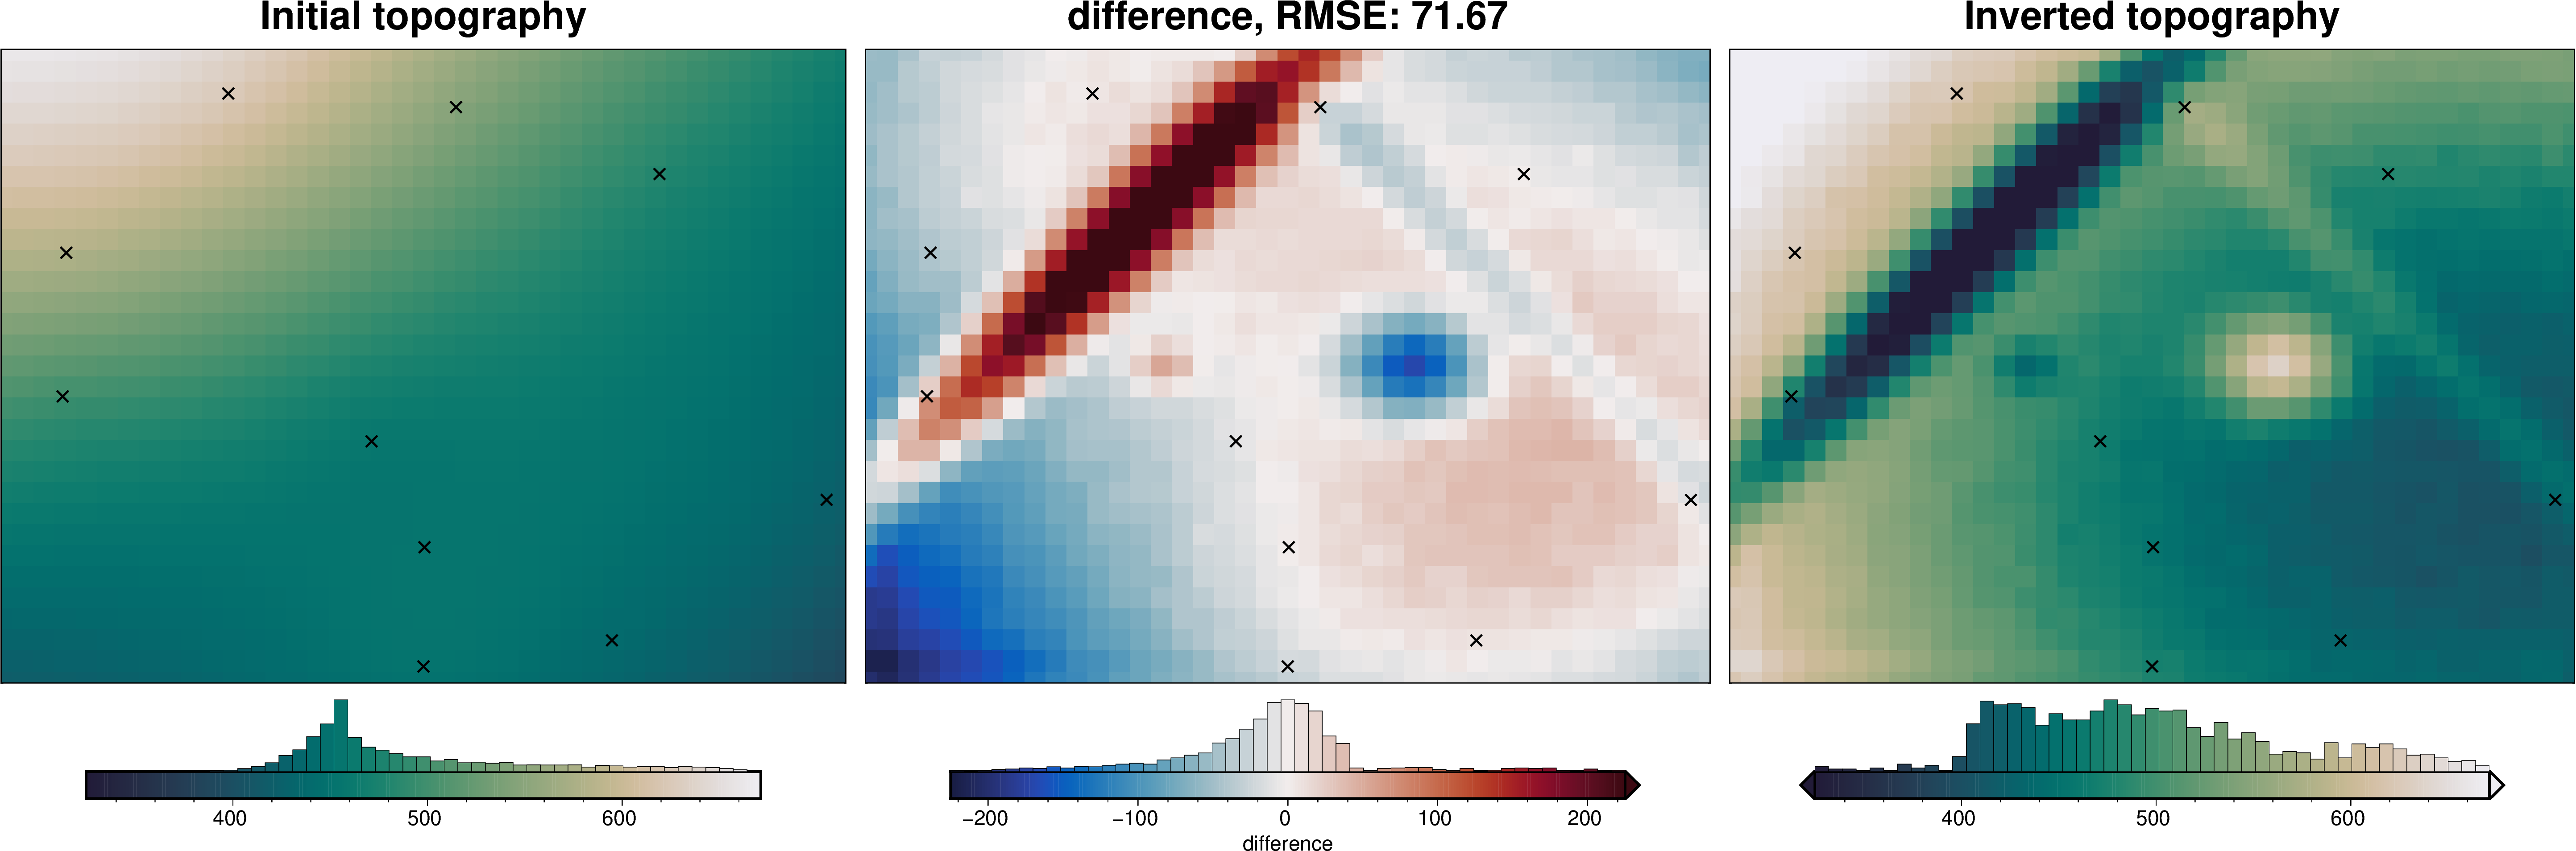

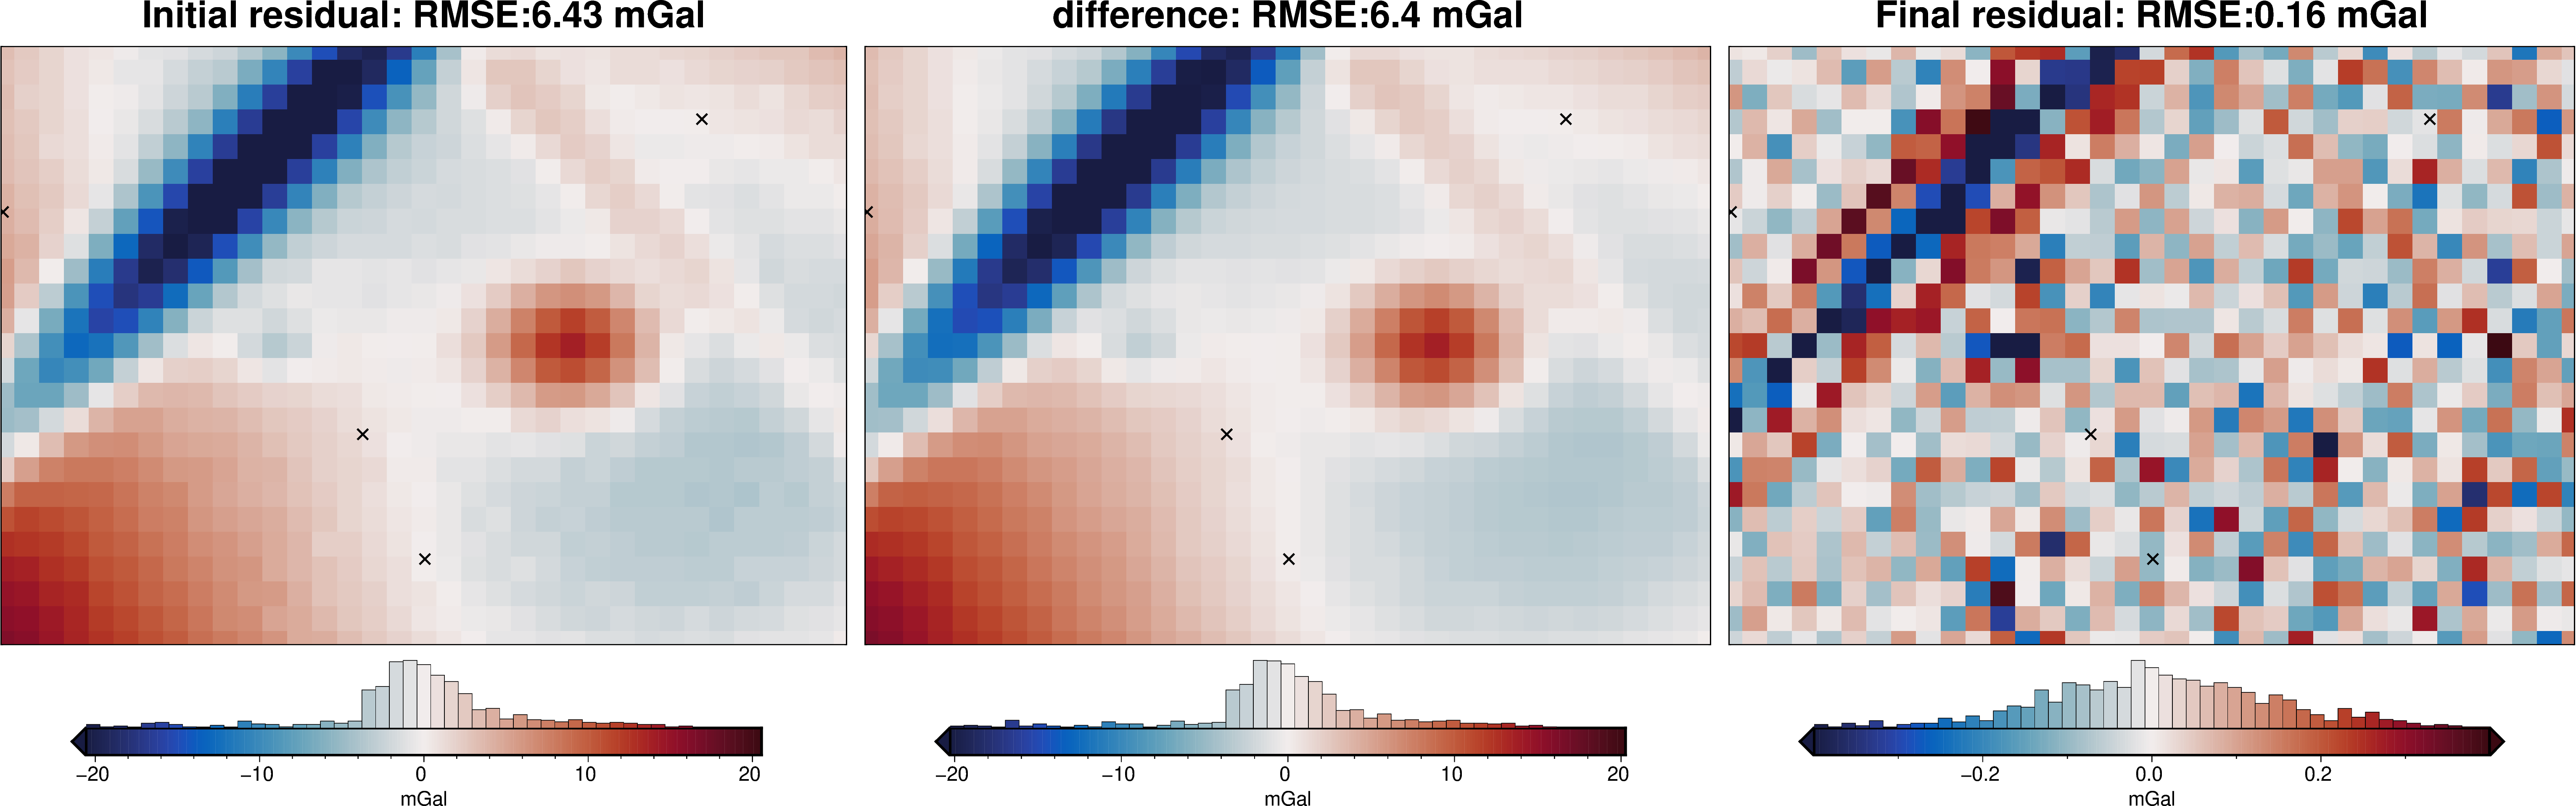

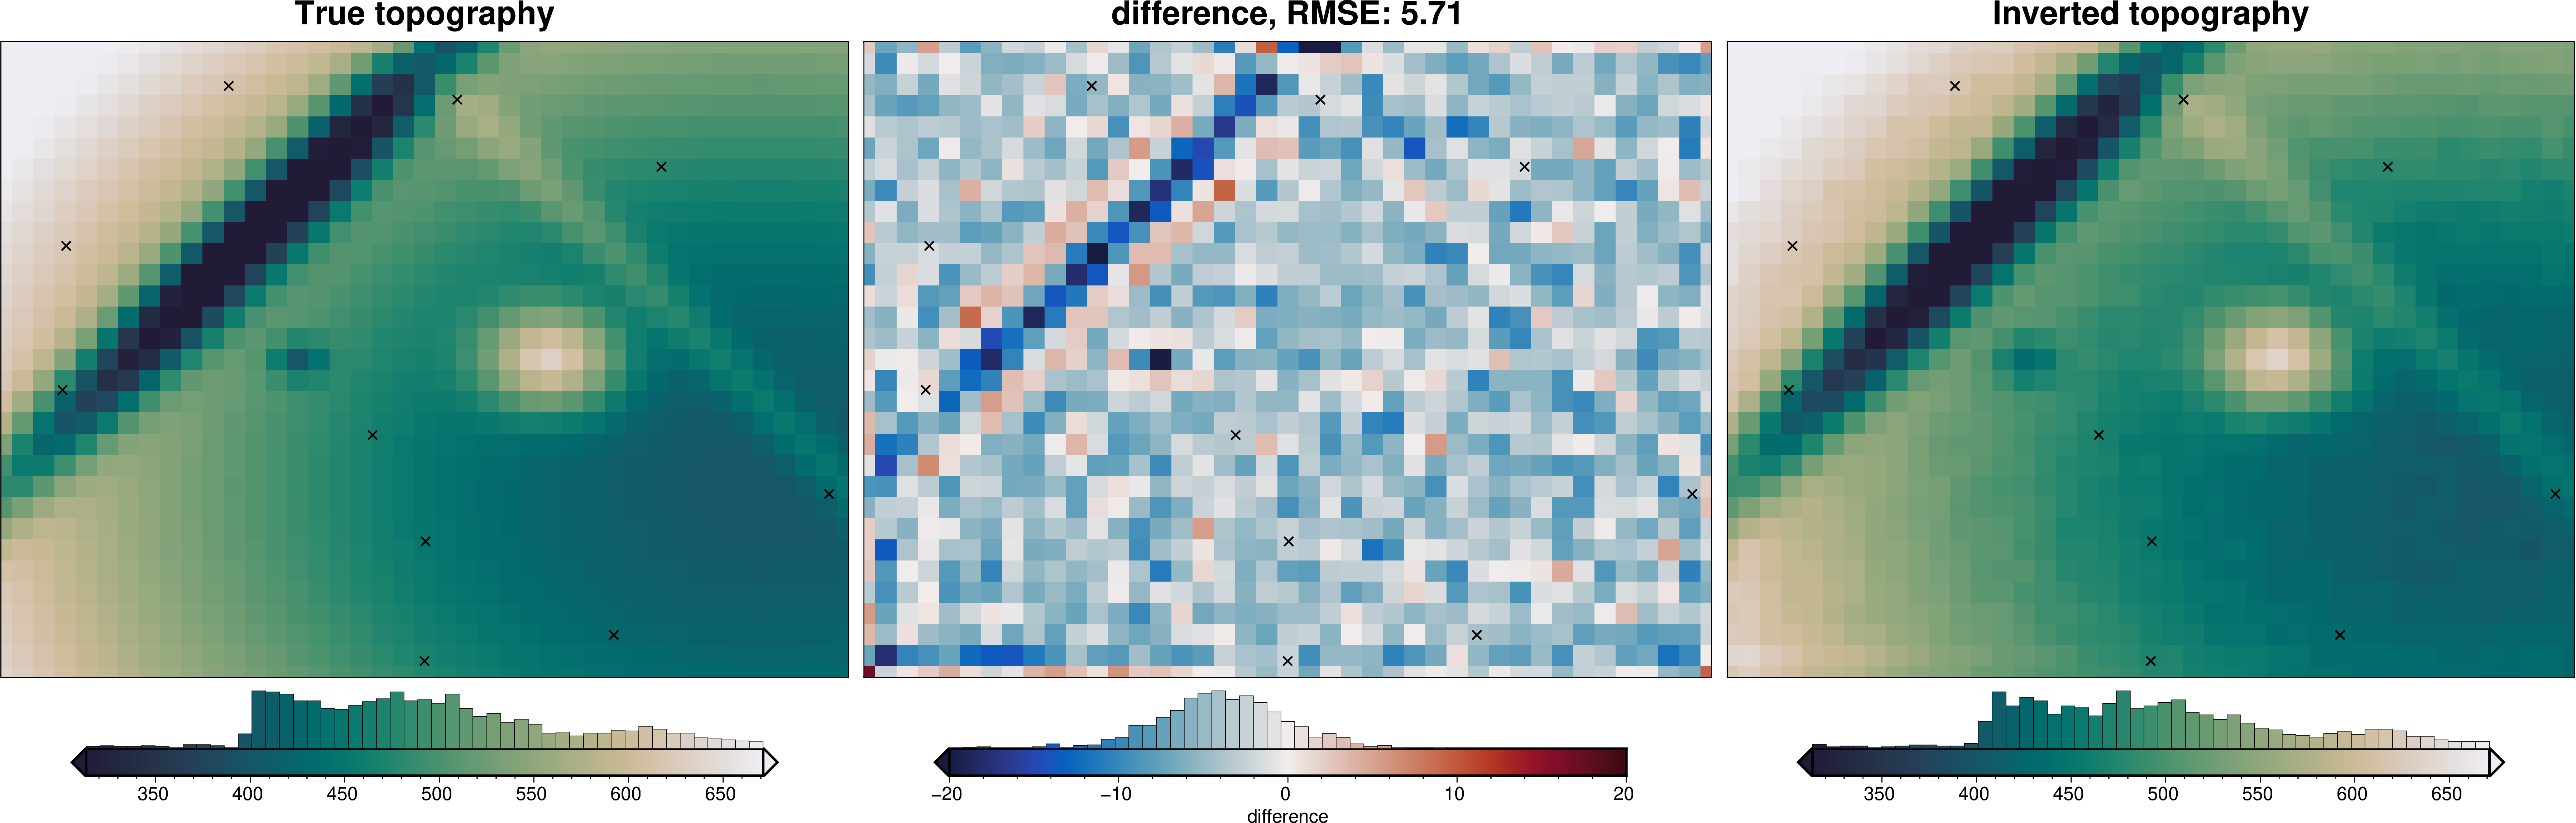

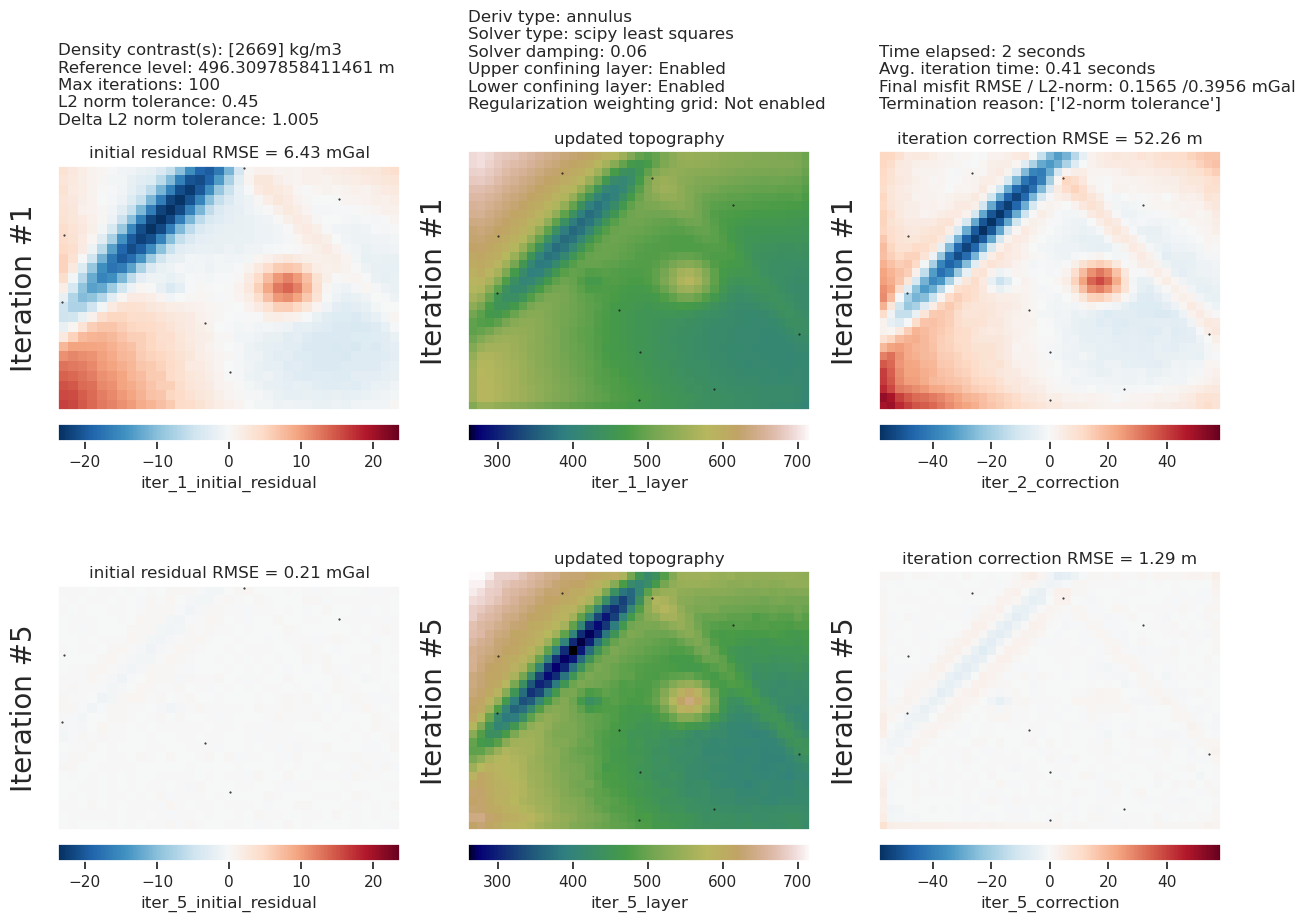

In [30]:
inv.plot_inversion_results(
    iters_to_plot=2,
    # plot_iter_results=False,
    # plot_topo_results=False,
    # plot_grav_results=False,
    constraints_df=constraint_points,
)

_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    diff_lims=(-20, 20),
    points=constraint_points,
    points_style="x.3c",
)

In [31]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 3.33 m


In [32]:
constraint_points

,easting,northing,upward,starting_topography,inverted_topography
0,3052.331575,20376.899884,619.779099,580.163740,622.402549
1,31196.751690,24112.171083,479.563412,481.652035,481.810412
2,17536.369258,11428.233994,465.786893,458.230368,468.817698
3,28938.607113,1978.090407,426.413502,438.512760,430.552931
4,39119.580480,8644.367979,428.773305,425.210470,433.235662
5,21539.834816,27287.805832,546.901160,547.287244,548.811518
6,20044.818546,6401.560607,450.406755,455.069067,452.342853
7,2882.045334,13563.718855,460.979806,499.138482,459.679617
8,10737.559204,27936.180591,614.084318,624.948915,620.201036
9,19995.300033,746.976827,470.409607,452.397262,472.847305


The RMSE between the constraint's true values and the inverted topography at the constraint's is not 0. This shows that while the starting model helped the inversion, the actual values of the constraints is not adhered too. The next inversion (`adhering_to_constraints.ipynb`) will show how to help the model stick to the constraints. 